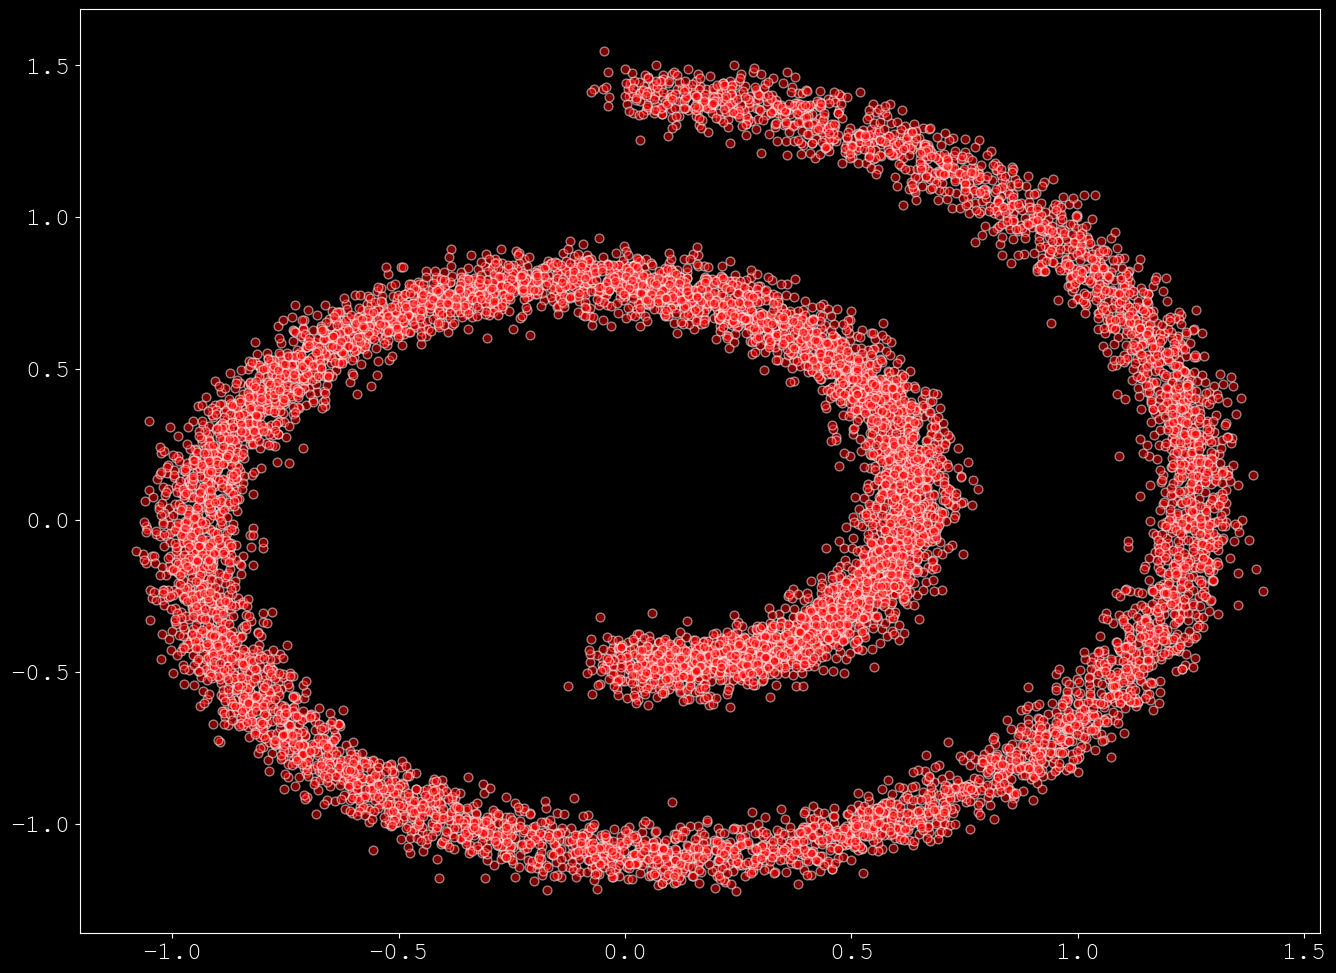

In [1]:
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
from matplotlib import animation

hdr_plot_style()

# Sample a batch from the swiss roll
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# Plot it
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=40)
data = data.T

In [2]:
import models.utils as mutils
from sde_lib import *
from sampling import *
from datasets import *
from losses import *

In [3]:
import flax.linen as nn
from ml_collections import ConfigDict

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  embed_dim: int
  scale: float = 30.
  @nn.compact
  def __call__(self, x):    
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    W = self.param('W', jax.nn.initializers.normal(stddev=self.scale), 
                 (self.embed_dim // 2, ))
    W = jax.lax.stop_gradient(W)
    x_proj = x[:, None] * W[None, :] * 2 * jnp.pi
    return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)

class ConditionalLinear(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x, y):
        out = nn.Dense(self.num_outputs)(x)
        embed = GaussianFourierProjection(self.num_outputs)(y)
        embed = nn.Dense(self.num_outputs)(embed)
        return embed + out

@mutils.register_model(name="cond_linear")
class ConditionalModel(nn.Module):
    config: ConfigDict
    @nn.compact
    def __call__(self, x, y, train=True):
        x = ConditionalLinear(config.model.hidden_size)(x, y)
        x = nn.leaky_relu(x)
        x = ConditionalLinear(config.model.hidden_size)(x, y)
        x = nn.leaky_relu(x)
        x = ConditionalLinear(config.model.hidden_size)(x, y)
        x = nn.leaky_relu(x)
        x = nn.Dense(config.model.output_size)(x)
        return x

In [4]:
config = ConfigDict()
config.seed = 42
config.model = model = ConfigDict()
model.name="cond_linear"
model.hidden_size = 128
model.output_size = 2
model.ema_rate = 0
model.beta_max = 10
model.beta_min = 1e-2
model.num_scales = 1000
model.sigma_max = 1
model.sigma_min = 1e-2
config.optim = optim = ConfigDict()
optim.optimizer = "Adam"
optim.lr = 1e-3
optim.beta1 = 0.9
optim.eps = 1e-8
optim.grad_clip = 1.

config.training = training = ConfigDict()
training.sde = "VPSDE"
training.snapshot_sampling = True
training.likelihood_weighting = False
training.continuous = True
training.n_jitted_steps = 5
training.reduce_mean = True
training.num_train_steps = 5000
training.batch_size = 5000
training.pmap = False

config.sampling = sampling = ConfigDict()
sampling.method = 'pc'
sampling.predictor = 'reverse_diffusion'
# sampling.predictor = 'none'
sampling.corrector = 'ald'
sampling.n_steps_each = 1
sampling.noise_removal = True
sampling.probability_flow = True
sampling.snr = 0.17

config.data = ConfigDict()
config.data.centered = False
config.data.shape = (2,)

In [5]:
rng = jax.random.PRNGKey(config.seed)
rng, step_rng = jax.random.split(rng)
score_model = mutils.get_model(config.model.name)(config)
input_shape = (jax.local_device_count(), 2 )
fake_input = jnp.zeros(input_shape)
fake_label = jnp.zeros(input_shape[:1], dtype=jnp.int32)
rng, params_rng = jax.random.split(rng)
variables = score_model.init(params_rng, fake_input, fake_label)
init_model_state, initial_params = variables.pop('params')
optimizer = get_optimizer(config)
state = mutils.State(step=0, apply_fn=score_model.apply,
                         params=initial_params,
                         tx=optimizer,
                         opt_state=optimizer.init(initial_params),
                         model_state=init_model_state,
                         ema_rate=config.model.ema_rate,
                         params_ema=initial_params,
                         rng=rng)
if config.training.sde.lower() == 'vpsde':
    sde = sde_lib.VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
    sampling_eps = 1e-3
elif config.training.sde.lower() == 'subvpsde':
    sde = sde_lib.subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max,
                            N=config.model.num_scales)
    sampling_eps = 1e-3
elif config.training.sde.lower() == 'vesde':
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max,
                        N=config.model.num_scales)
    sampling_eps = 1e-5
else:
    raise NotImplementedError(f"SDE {config.training.sde} unknown.")
optimize_fn = optimization_manager(config)
train_step_fn = get_step_fn(sde, score_model, train=True, optimize_fn=optimize_fn, reduce_mean = config.training.reduce_mean, continuous=config.training.continuous, likelihood_weighting=config.training.likelihood_weighting, pmap=config.training.pmap)
# p_train_step = jax.pmap(functools.partial(jax.lax.scan, train_step_fn), axis_name='batch')
eval_step_fn = get_step_fn(sde, score_model, train=False, optimize_fn=optimize_fn, reduce_mean = config.training.reduce_mean, continuous=config.training.continuous, likelihood_weighting=config.training.likelihood_weighting, pmap=config.training.pmap)
# p_eval_step = jax.pmap(functools.partial(jax.lax.scan, eval_step_fn), axis_name='batch')

In [6]:
num_train_steps = config.training.num_train_steps
rng = jax.random.fold_in(rng, jax.process_index())

In [7]:

from tqdm import tqdm
train_step_fn = jax.jit(train_step_fn)
batch_size = config.training.batch_size
rng = jax.random.PRNGKey(0)
tqdmbar = tqdm(range(0, num_train_steps))
for t in tqdmbar:
    # batch_idx = np.random.choice(data.shape[0], size=batch_size, replace=False)
    permutation = np.random.permutation(data.shape[0])
    for i in range(0, data.shape[0], batch_size):
      batch_idx = permutation[i:i+batch_size]
      batch = {'data': data[batch_idx]}
      (rng, state), loss = train_step_fn((rng, state), batch)
    if (t+1) % 100 == 0:
      tqdmbar.set_description(f"Loss: {loss:.4f}")

Loss: 0.2875: 100%|██████████| 5000/5000 [00:10<00:00, 458.73it/s]


In [8]:
pstate = flax.jax_utils.replicate(state)

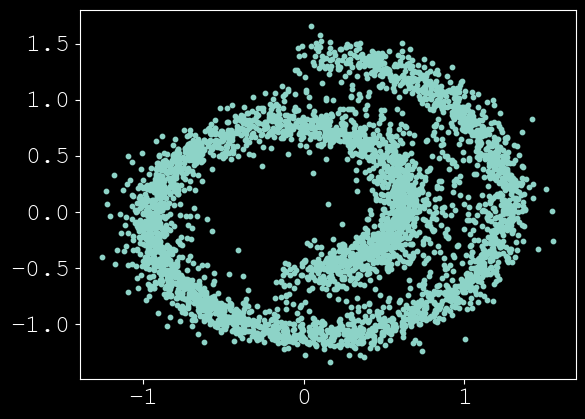

In [9]:
inverse_scaler = get_data_inverse_scaler(config)
sampling_fn = get_sampling_fn(config, sde, score_model, (1000, 2), inverse_scaler, eps=sampling_eps)
rng, *next_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
next_rng = jnp.asarray(next_rng)
sample, n = sampling_fn(next_rng, pstate)
gen_x = jax.device_get(sample.reshape(-1, 2))
plt.scatter(gen_x[:, 0], gen_x[:, 1], s=10)
plt.show()

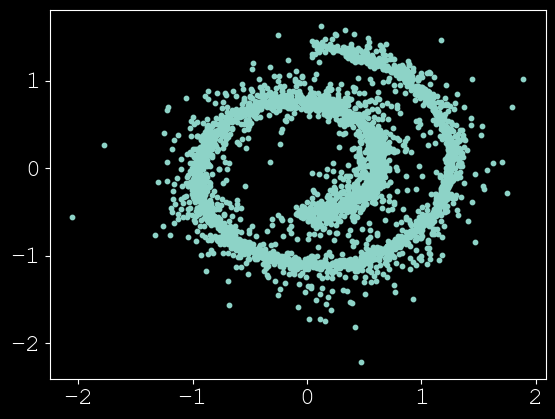

In [10]:
sampling_fn = get_ode_sampler(sde, score_model, (1000, 2), lambda x: x, eps=sampling_eps)
rng, *next_rng = jax.random.split(rng, num=jax.local_device_count() + 1)
next_rng = jnp.asarray(next_rng)
sample, n = sampling_fn(next_rng, pstate)
gen_x = jax.device_get(sample.reshape(-1, 2))
plt.scatter(gen_x[:, 0], gen_x[:, 1], s=10)
plt.show()